<a href="https://colab.research.google.com/github/jacr2006/AICamera/blob/master/Notebooks/CNN/data_trainning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook extract mid-term features from labeled audio files (.wav), and create a matrix of features and a vector of classes. Next, a trainning using a CNN is done. The model obtained is used for testing.

In [ ]:
pip install torchaudio

     |████████████████████████████████| 7.6MB 7.4MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [ ]:
import torchaudio.transforms
import torch

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import IPython.display as ipd

import shutil

import librosa

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import preprocessing

import pickle

from tensorflow import keras
from tensorflow.keras import layers

/usr/local/lib/python3.6/dist-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# source file directory
PATH_DRIVE = '/content/drive/MyDrive/Colab Notebooks/'

## Training

In [ ]:
f = np.load(PATH_DRIVE + "f.npy", allow_pickle=True)
f_avg = np.load(PATH_DRIVE + "f_avg.npy", allow_pickle=True)
c = np.load(PATH_DRIVE + "c.npy", allow_pickle=True)

In [ ]:
f.shape

(1267, 173, 40)

In [ ]:
#from sklearn.preprocessing import StandardScaler

#ss = StandardScaler()
#ff = ss.fit_transform(f.reshape(-1, f.shape[-1])).reshape(f.shape)

In [ ]:
#data standarization
#ff = preprocessing.scale(f)

#data scalling (min-max) for improve prediction accurancy
#min_max_scaler = preprocessing.MinMaxScaler()
#ff = min_max_scaler.fit_transform( f.reshape(-1, f.shape[-1]) ).reshape(f.shape)

In [ ]:
#ff.shape

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.regularizers import l2

# Encode the classification labels to one-hot
le = LabelEncoder()
cc = to_categorical(le.fit_transform(c)) 
cc.shape

(1267, 10)

In [ ]:
# Classes according Urban Dataset
num_classes = 10

In [ ]:
# Training and test split 
X_train, X_test, y_train, y_test = train_test_split(f, cc, test_size=0.05,random_state=0) # 95% for training - 5% for  testing

In [ ]:
print( X_train.shape )
print( X_test.shape )

(1203, 173, 40)
(64, 173, 40)


In [ ]:
# Model


# cnn model

X_train = np.expand_dims(X_train, axis=3)
print( X_train.shape )
X_test = np.expand_dims(X_test, axis=3)
print( X_test.shape )

input_shape = ( X_train.shape[1], X_train.shape[2], 1  )

model = keras.Sequential()
model.add(keras.layers.Conv2D(128, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(keras.layers.Conv2D(128, kernel_size=3, activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Conv2D(256, kernel_size=3, activation='relu'))
model.add(keras.layers.Conv2D(256, kernel_size=3, activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size = (2, 2)))
model.add(keras.layers.Dropout(0.20))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_classes, activation='softmax'))


'''
# LSTM model

input_shape = ( X_train.shape[1], X_train.shape[2]  )

model = keras.Sequential()
model.add(keras.layers.LSTM(256, input_shape=input_shape, return_sequences=False))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_classes, activation='softmax'))
'''


'''
# mix model

input_cnn = ( X_train.shape[1], X_train.shape[2], 1  )
input_lstm = ( X_train.shape[1], X_train.shape[2]  )

X_train_c = np.expand_dims(X_train, axis=3)
print( X_train.shape )
X_test_c = np.expand_dims(X_test, axis=3)
print( X_test.shape )


cnn_in = keras.Input(shape=input_cnn)
x = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_in)
x = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.15)(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)
x = keras.layers.Dropout(0.20)(x)
cnn_model = keras.layers.Flatten()(x)

rnn_in = keras.Input(shape=input_lstm)
x = keras.layers.LSTM(256, return_sequences=False)(rnn_in)
x = keras.layers.Dropout(0.20)(x)
rnn_model = keras.layers.Flatten()(x)

x = keras.layers.Concatenate()([cnn_model, rnn_model])

x = keras.layers.Dense(1024)(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.Dropout(0.5)(x)
conc_model = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=[cnn_in, rnn_in], outputs=conc_model)

# for fit input, use
# history = model.fit( [X_train_c, X_train], y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2 )
'''


(1203, 173, 40, 1, 1)
(64, 173, 40, 1, 1)


"\n# mix model\n\ninput_cnn = ( X_train.shape[1], X_train.shape[2], 1  )\ninput_lstm = ( X_train.shape[1], X_train.shape[2]  )\n\nX_train_c = np.expand_dims(X_train, axis=3)\nprint( X_train.shape )\nX_test_c = np.expand_dims(X_test, axis=3)\nprint( X_test.shape )\n\n\ncnn_in = keras.Input(shape=input_cnn)\nx = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(cnn_in)\nx = keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)\nx = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)\nx = keras.layers.Dropout(0.15)(x)\nx = keras.layers.Conv2D(128, kernel_size=3, activation='relu')(x)\nx = keras.layers.Conv2D(128, kernel_size=3, activation='relu')(x)\nx = keras.layers.MaxPooling2D(pool_size = (2, 2))(x)\nx = keras.layers.Dropout(0.20)(x)\ncnn_model = keras.layers.Flatten()(x)\n\nrnn_in = keras.Input(shape=input_lstm)\nx = keras.layers.LSTM(256, return_sequences=False)(rnn_in)\nx = keras.layers.Dropout(0.20)(x)\nrnn_model = keras.layers.Flatten()(x)\n\nx = keras.layers.Concatena

In [ ]:
batch_size = 64
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

In [ ]:
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_56 (Conv2D)           (None, 171, 38, 128)      1280      
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 169, 36, 128)      147584    
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 84, 18, 128)       0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 84, 18, 128)       0         
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 82, 16, 256)       295168    
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 80, 14, 256)       590080    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 40, 7, 256)      

In [ ]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/20
16/16 [==============================] - 230s 14s/step - loss: 4.2637 - accuracy: 0.1666 - val_loss: 2.5234 - val_accuracy: 0.2905
Epoch 2/20
16/16 [==============================] - 225s 14s/step - loss: 2.2083 - accuracy: 0.2799 - val_loss: 2.0947 - val_accuracy: 0.3237
Epoch 3/20
16/16 [==============================] - 224s 14s/step - loss: 1.9615 - accuracy: 0.3506 - val_loss: 1.8318 - val_accuracy: 0.3610
Epoch 4/20
16/16 [==============================] - 225s 14s/step - loss: 1.7148 - accuracy: 0.3955 - val_loss: 1.6632 - val_accuracy: 0.4232
Epoch 5/20
16/16 [==============================] - 225s 14s/step - loss: 1.5739 - accuracy: 0.4170 - val_loss: 1.5350 - val_accuracy: 0.5228
Epoch 6/20
16/16 [==============================] - 224s 14s/step - loss: 1.4042 - accuracy: 0.5135 - val_loss: 1.4447 - val_accuracy: 0.5643
Epoch 7/20
16/16 [==============================] - 225s 14s/step - loss: 1.3121 - accuracy: 0.5402 - val_loss: 1.3579 - val_accuracy: 0.5602
Epoch 

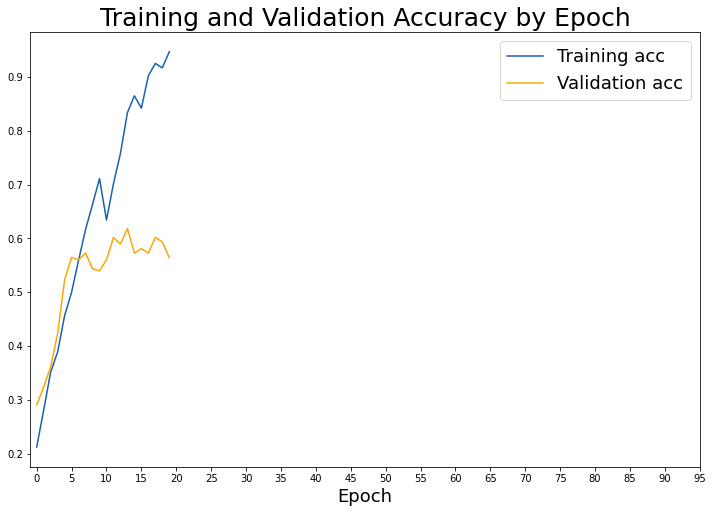

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
# Set figure size.
plt.figure(figsize=(12, 8))
# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training acc', color='#185fad')
plt.plot(val_accuracy, label='Validation acc', color='orange')
# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))
plt.legend(fontsize = 18);

In [ ]:
# Save model for inference
model.save(PATH_DRIVE+'audio_classificator_cnn_model_v1.h5')